In [160]:
import numpy as np
import tensorflow as tf

default_padding='SAME'

def layer(op):
    def decorator(self,*args,**kwargs):
        name=kwargs['name']

        cur_input=self.input[0]
        cur_output=op(self,cur_input,*args,**kwargs)
        self.layers[name]=cur_output
        self.feed(name)

        return self
    return decorator


class Network(object):

    def __init__(self,input):
        self.input=[]
        self.layers=dict(input)
        
        self.setup()

    def setup(self):
        #必须被子类具体化
        raise NotImplementedError('Must be subclassed')


    def get_output(self,layer):
        assert layer in self.layers.keys(),"Invalid Keys"
        return self.layers[layer]

    def feed(self,*args):
        assert len(args)!=0

        self.input=[]
        for i in args:
            self.input.append(self.layers[i])
        return self

    def make_var(self,name,shape,initializer):
        return  tf.get_variable(name,shape,initializer=initializer)

    @layer
    def conv(self,input,k_w,k_h,c_o,s_w,s_h,name,relu=True,padding=default_padding):
        c_i=input.get_shape()[-1]

        convolve=lambda i,f: tf.nn.conv2d(i,f,[1,s_w,s_h,1],padding=padding)

        with tf.variable_scope(name,reuse=tf.AUTO_REUSE) as scope:
            init_weights=tf.truncated_normal_initializer(0.0,stddev=0.01)
            init_biases=tf.constant_initializer(0.0)
            filters=self.make_var("weights",[k_w,k_h,c_i,c_o],init_weights)
            biases=self.make_var("biases",[c_o],init_biases)

            output=convolve(input,filters)

            if relu:
                biases=tf.nn.bias_add(output,biases)
                return tf.nn.relu(biases,name=scope.name)
            else:
                return tf.nn.bias_add(output,biases,name=scope.name)
    @layer
    def max_pool(self,input,k_w,k_h,s_w,s_h,name,padding=default_padding):
        return tf.nn.max_pool(input,ksize=[1,k_h,k_w,1],
                              strides=[1,s_h,s_w,1],
                              padding=padding,
                              name=name)
    @layer
    def reshape(self,input,name):
        output=tf.reshape(input,[input.get_shape()[0],-1],name=name)
        return output

    @layer
    def fc(self,input,o_dim,name,relu=True):
        with tf.variable_scope(name,reuse=tf.AUTO_REUSE) as scope:
            input_shape=input.get_shape()
            feed_in, dim = (input, input_shape[-1])
            init_weights = tf.truncated_normal_initializer(0.0, stddev=0.01)
            init_biases = tf.constant_initializer(0.0)

            weights = self.make_var('weights', [dim, o_dim], init_weights)
            biases = self.make_var('biases', [o_dim], init_biases)

            op=tf.nn.relu_layer if relu else tf.nn.xw_plus_b
            return op(feed_in,weights,biases,name=scope.name)

    @layer
    def softmax(self,input,name):
        return tf.nn.softmax(input,name=name)

In [161]:
class Vgg16_train(Network):

    def __init__(self):
        self.input=[]
        self.data=tf.placeholder(tf.float32,shape=[2,224,224,3])
        self.labels=tf.placeholder(tf.float32,shape=[2,1])
        self.layers={'data':self.data,'labels':self.labels}
        self.setup()

    def setup(self):
        (self.feed('data')
             .conv(3,3,64,1,1,name='conv1_1')
             .conv(3,3,64,1,1,name='conv1_2')
             .max_pool(2,2,2,2,name='pool1',padding='VALID')
             .conv(3,3,128,1,1,name='conv2_1')
             .conv(3,3,128,1,1,name='conv2_2')
             .max_pool(2,2,2,2,name='pool2',padding='VALID')
             .conv(3,3,256,1,1,name='conv3_1')
             .conv(3,3,256,1,1,name='conv3_2')
             .conv(3,3,256,1,1,name='conv3_3')
             .max_pool(2,2,2,2,name='pool3',padding='VALID')
             .conv(3,3,512,1,1,name='conv4_1')
             .conv(3,3,512,1,1,name='conv4_2')
             .conv(3,3,512,1,1,name='conv4_3')
             .max_pool(2,2,2,2,name='pool4',padding='VALID')
             .conv(3,3,512,1,1,name='conv5_1')
             .conv(3,3,512,1,1,name='conv5_2')
             .conv(3,3,512,1,1,name='conv5_3')
             .max_pool(2,2,2,2,name='pool5',padding='VALID')
             .reshape(name='reshape6')
             .fc(4096,name='fc6')
             .fc(4096,name='fc7')
             .fc(2622,name='fc8',relu=False)
             .softmax(name='cls_prob'))

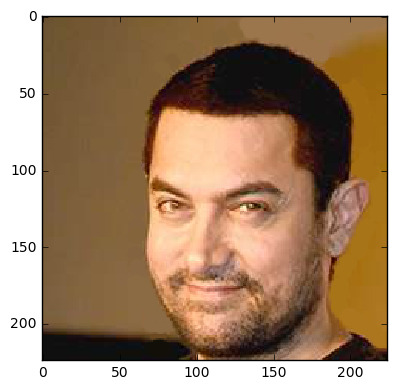

In [169]:
import skimage.io as skii
img=skii.imread("Aamir_Khan_March_2015.jpg")
img_test=img[:224,:224,:]
skii.imshow(img_test)
skii.show()
# img_test=np.vstack((img_test,img_test))

In [163]:
labels=np.array([[1,1]])

In [164]:
img_test=img_test.reshape(-1,224,224,3)
labels=labels.reshape(-1,1)

In [165]:
vgg=Vgg16_train()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    cls=vgg.get_output('cls_prob')
    feed_dict={vgg.data:img_test,vgg.labels:labels}
    cls_pro=sess.run(cls,feed_dict=feed_dict)
    print(cls_pro.shape)

(2, 2622)


In [ ]:
tf.train.GradientDescentOptimizer